In [1]:
import albumentations as A
import torch
import json
import cv2
import numpy as np
import os
from torch.utils.data import Dataset
import glob
import segmentation_models_pytorch as smp

from segmentation_models_pytorch import utils
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from pywget import wget
from dataloaders import BalloonDatasetSegmentation, BalloonLoaders
from utils import *

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

## Create masks

In [3]:
# link = "https://github.com/matterport/Mask_RCNN/releases/download/v2.1/balloon_dataset.zip"
# wget.download(link)

In [4]:
# !unzip balloon_dataset.zip

In [5]:
def create_labels(dataset_type='train'):
    f = open(f'balloon\\{dataset_type}\\via_region_data.json')
    json_file = json.load(f)
    for file in json_file:
        path = f'balloon\\{dataset_type}'
        filename = json_file[file]['filename']

        path_to_mask = f"{path}\\masks\\{filename.replace('.jpg', '.png')}"

        if os.path.exists(path_to_mask):
            continue
        else:                
            img = cv2.imread(f'{path}\\{filename}')
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            regions = json_file[file]['regions']
            label = np.zeros_like(img)

            for n in regions:
                mask = np.zeros((img.shape[0], img.shape[1]))
                x_coords = regions[n]['shape_attributes']['all_points_x']
                y_coords = regions[n]['shape_attributes']['all_points_y']
                coords_of_polygon = np.dstack((x_coords, y_coords))
                cv2.fillConvexPoly(mask, coords_of_polygon, 1)
                mask = mask.astype(bool)
                label[mask] = 1
            cv2.imwrite(path_to_mask, label)

In [6]:
create_labels('train')
create_labels('val')

## Augmentations

In [7]:
def get_training_augmentation():
    train_transform = [
        A.Resize(height=512, width=512, p=1),
        
        A.HorizontalFlip(p=0.5),      
        A.PadIfNeeded(min_height=512, min_width=512, always_apply=True, border_mode=0),
        A.RandomCrop(height=512, width=512, always_apply=True),
        A.ShiftScaleRotate(scale_limit=0.5, 
                            rotate_limit=0, 
                            shift_limit=0.1, 
                            p=1, 
                            border_mode=0),
        A.GaussNoise (p=0.2),
        A.Perspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.Sharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomBrightnessContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return A.Compose(train_transform)

In [8]:
ENCODER = 'mobilenet_v2'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid'
DEVICE = 'cuda'

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(eps=1., activation = None),
]

In [9]:
class My_network():
    def __init__(self, loss, metrics):
        self.model = smp.Unet(
            encoder_name=ENCODER, 
            encoder_weights=ENCODER_WEIGHTS, 
            classes=1, 
            activation=ACTIVATION,
        )
        
        self.optimizer = torch.optim.Adam([ 
            dict(params=self.model.parameters(), lr=0.0001),
        ])
        
        self.train_epoch = smp.utils.train.TrainEpoch(
            self.model, 
            loss=loss, 
            metrics=metrics, 
            optimizer= self.optimizer,
            device=DEVICE,
            verbose=False,
        )

        self.valid_epoch = smp.utils.train.ValidEpoch(
            self.model, 
            loss=loss, 
            metrics=metrics, 
            device=DEVICE,
            verbose=False,
        )
    def run_training(self, loaders, n_epochs=40, save_name='./best_model.pth'):
        max_score = 0
        for i in range(0, n_epochs):

            train_logs = self.train_epoch.run(loaders.train_loader)
            valid_logs = self.valid_epoch.run(loaders.valid_loader)

            if i%10==0: 
                print(f'==Epoch {i}==')
                print('Train/Val IoU:')
                print(round(train_logs['iou_score'] , 2))
                print(round(valid_logs['iou_score'] , 2))

            if max_score < valid_logs['iou_score']:
                max_score = valid_logs['iou_score']
                torch.save(self.model, save_name)

In [10]:
network = My_network(loss, metrics)

C:\Users\yaroslav\anaconda3\envs\ml-env\lib\site-packages\albumentations\augmentations\transforms.py:1149: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


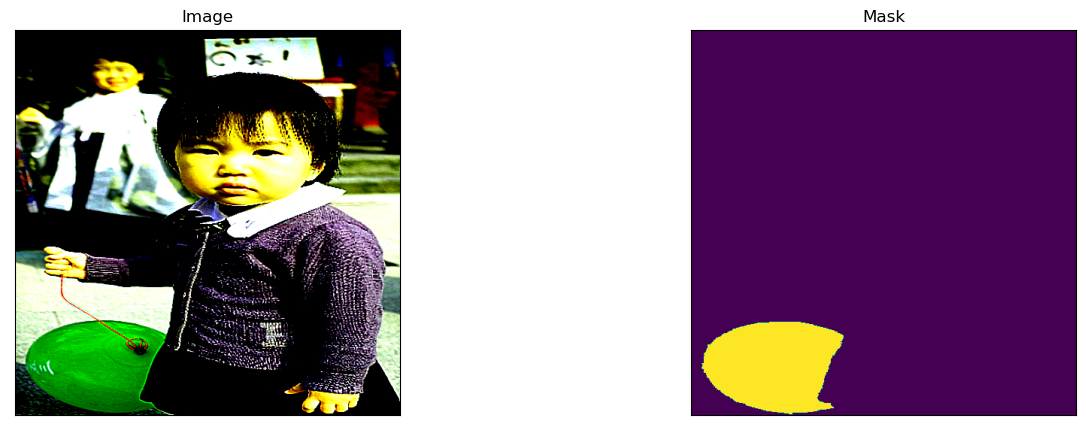

In [11]:
balloon_loaders = BalloonLoaders(augmentation=get_training_augmentation(), preprocessing_fn=preprocessing_fn)
balloon_loaders.show_example()

In [12]:
network.run_training(balloon_loaders)

==Epoch 0==
Train/Val IoU:
0.19
0.19
==Epoch 10==
Train/Val IoU:
0.72
0.53
==Epoch 20==
Train/Val IoU:
0.73
0.69
==Epoch 30==
Train/Val IoU:
0.85
0.85


In [13]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth')

In [14]:
test_dataloader = DataLoader(balloon_loaders.test_dataset)
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 13/13 [00:01<00:00,  9.09it/s, dice_loss - 0.2817, iou_score - 0.8509]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


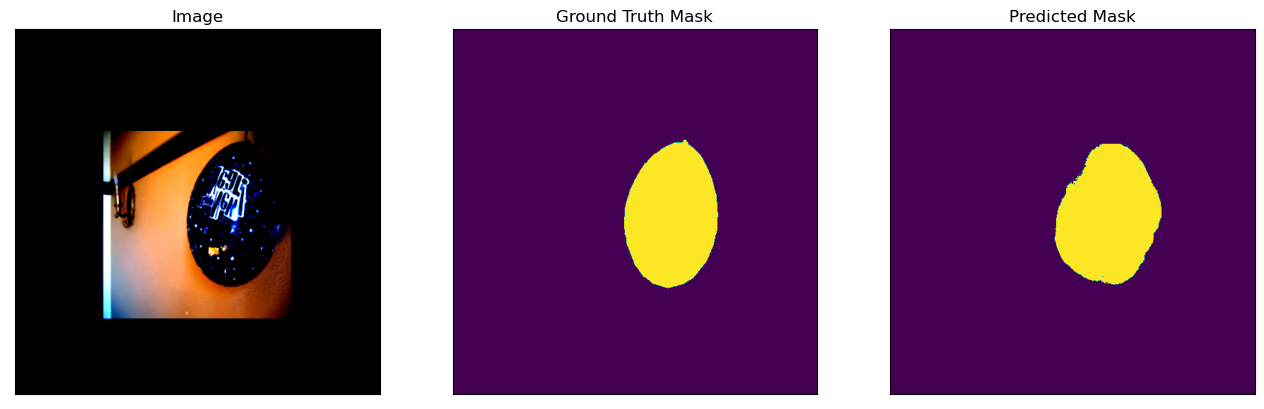

In [15]:
compare_predictions(balloon_loaders, best_model)

## Without augmentations

In [ ]:
network_without_aug = My_network(loss, metrics)
balloon_loaders = BalloonLoaders(augmentation=BalloonLoaders.minimal_transformations(), preprocessing_fn=preprocessing_fn)
network_without_aug.run_training(balloon_loaders, save_name='./best_model_without_aug.pth')

In [ ]:
# load best saved checkpoint
best_model = torch.load('./best_model_without_aug.pth')

In [ ]:
test_dataloader = DataLoader(balloon_loaders.test_dataset)
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True
)

logs = test_epoch.run(test_dataloader)

In [ ]:
for _ in range(5):
    compare_predictions(balloon_loaders, best_model)